# Exploratory data analysis (EDA)

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/Users/xinyitan/Projects/Challenges/DoorDash')

In [2]:
df = pd.read_csv('historical_data.csv', parse_dates = ['created_at', 'actual_delivery_time'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   subtotal                                      197428 non-null  int64         
 5   total_onshift_dashers                         181166 non-null  float64       
 6   total_busy_dashers                            181166 non-null  float64       
 7   total_outstanding_orders                      181166 non-null  float64       
 8   estimated_store_to_consumer_driving_duration  196902 no

In [4]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0


## Step 1: Target variable

### Summary of findings
1) created `delivery_duration_seconds` as target  
2) found 7 missing values - **To do: delete**    
3) found outliers - **To do: reasonable floor and cap values could be 10min and 2h**

In [31]:
# calculate delivery duration in seconds

df['delivery_duration_seconds'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()
df['delivery_duration_seconds'].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    1.974210e+05
mean     2.908257e+03
std      1.922961e+04
min      1.010000e+02
1%       1.152000e+03
5%       1.492000e+03
10%      1.699000e+03
25%      2.104000e+03
50%      2.660000e+03
75%      3.381000e+03
90%      4.235000e+03
95%      4.872000e+03
99%      6.474800e+03
max      8.516859e+06
Name: delivery_duration_seconds, dtype: float64

In [32]:
# found 7 missing values
df['delivery_duration_seconds'].isnull().sum()

7

0.0055564560244747456

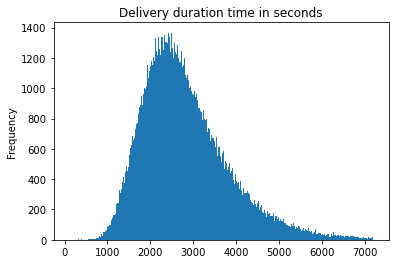

In [71]:
# find outliers - will cap and floor them for modeling data
cap_hour = 2
df1 = df[df['delivery_duration_seconds'] <= 60*60*cap_hour]

# plot for finding reasonable cap and floor values - 10 min to 2h
df1['delivery_duration_seconds'].plot.hist(bins = 500, title = "Delivery duration time in seconds")

# sizing the outliers
np.where(df['delivery_duration_seconds'] <= 60*60*2, 0, 1).mean()

### Simple cleaning for following analysis

In [8]:
# remove missing values
df1 = df.dropna(subset = ['delivery_duration_seconds'])

# floor at 10 min, cap at 2h
df1['delivery_duration_seconds_cf'] = df1['delivery_duration_seconds'].clip(60*10, 60*60*2)
df1.sort_values('delivery_duration_seconds').head()

# df1 now has 197421 values
target_variable = 'delivery_duration_seconds_cf'
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197421 entries, 0 to 197427
Data columns (total 11 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196434 non-null  float64       
 1   created_at                                    197421 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197421 non-null  int64         
 4   subtotal                                      197421 non-null  int64         
 5   total_onshift_dashers                         181159 non-null  float64       
 6   total_busy_dashers                            181159 non-null  float64       
 7   total_outstanding_orders                      181159 non-null  float64       
 8   estimated_store_to_consumer_driving_duration  196895 n

## Step 2: Independent variables

### Categorical variables
`market_id`: 6 distinct markets(cities/regions); has null values for market  
`store_id`: 6743 stores/restaurants; no missing values

<AxesSubplot:title={'center':'Relative % of market'}>

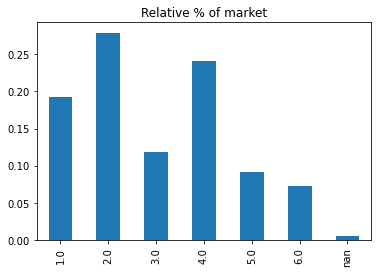

In [9]:
# categorical variable - market_id
# 1) found null values - will create missing flag
# 2) found 6 distinct markets - city or regions

df1['market_id'].value_counts(normalize = True, dropna = False).sort_index().plot.bar(title = "Relative % of market")

In [10]:
# categorical variable - store_id
# 1) no missing values
# 2) found 6743 restaurants - too many for modeling. It might be helpful to get store features (locations, store types)

df1['store_id'].value_counts(normalize = True, dropna = False).sort_values(ascending = False)

6865    0.004746
1311    0.004371
314     0.004123
1686    0.003875
3937    0.003652
          ...   
6470    0.000005
6115    0.000005
4295    0.000005
6866    0.000005
4398    0.000005
Name: store_id, Length: 6743, dtype: float64

### Continuous variable - distribution and histograms

In [72]:
df1['total_notbusy_dashers'] = df1['total_onshift_dashers'] - df1['total_busy_dashers']

continuous_varlist = ['subtotal', 'total_onshift_dashers', 'total_busy_dashers', 
                      'total_notbusy_dashers', 'total_outstanding_orders'
                      ,'estimated_store_to_consumer_driving_duration']

# Distributions
df1[continuous_varlist].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,subtotal,total_onshift_dashers,total_busy_dashers,total_notbusy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
count,196331.000000,180152.000000,180152.000000,180152.000000,180152.000000,195807.000000
mean,2679.577143,44.856327,41.778981,3.077346,58.045611,544.898293
std,1819.874257,34.526811,32.146955,11.433817,52.632584,219.195760
min,0.000000,-4.000000,-5.000000,-64.000000,-6.000000,0.000000
1%,529.000000,0.000000,0.000000,-31.000000,0.000000,110.000000
5%,805.000000,4.000000,3.000000,-11.000000,3.000000,192.000000
10%,995.000000,7.000000,6.000000,-4.000000,7.000000,253.000000
25%,1400.000000,17.000000,15.000000,0.000000,17.000000,382.000000
50%,2200.000000,37.000000,34.000000,1.000000,41.000000,543.000000
75%,3392.000000,65.000000,62.000000,6.000000,85.000000,702.000000


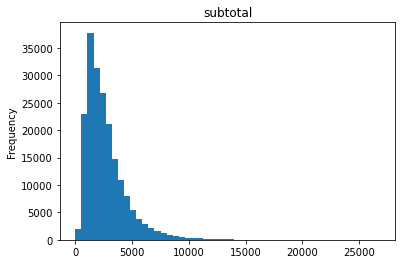

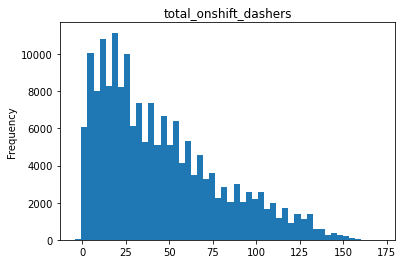

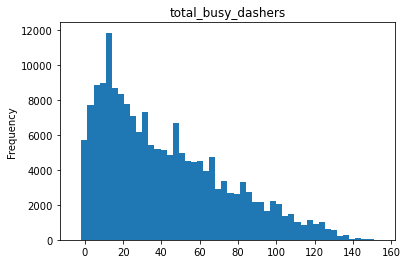

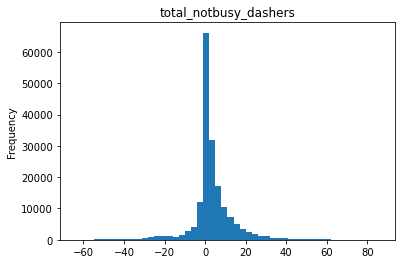

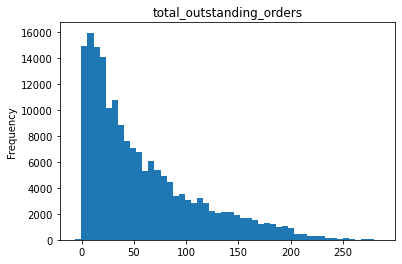

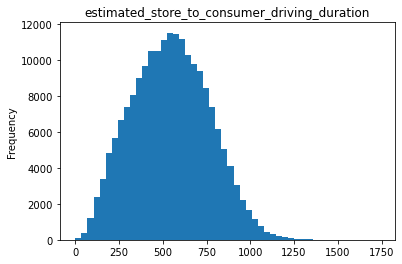

In [107]:
for var in continuous_varlist:
    df1[var].plot.hist(bins = 50, title = var)
    plt.show()

## Step 3: Check time effect

In [13]:
# transform created_time in UTC to local time in PST

from pytz import timezone
import pytz

def UTC_to_PST(UTC_datetime):
    return UTC_datetime.replace(tzinfo = pytz.utc).astimezone(tz = 'US/Pacific')
df1['created_PST'] = df1['created_at'].apply(UTC_to_PST)
df1['created_date'] = df1['created_PST'].dt.date
df1['created_day'] = df1['created_PST'].dt.weekday
df1['created_hour'] = df1['created_PST'].dt.hour

In [14]:
# group by date, day and hour

df1_group_by_date = df1.groupby('created_date')
df1_group_by_day = df1.groupby('created_day')
df1_group_by_hour = df1.groupby('created_hour')

### Variable stability by date

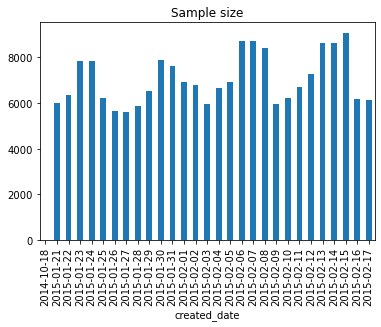

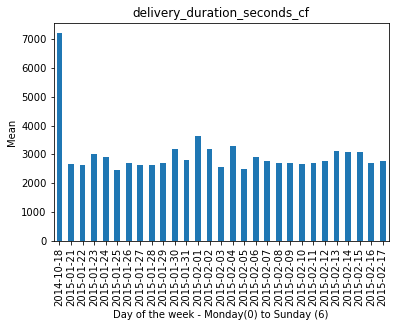

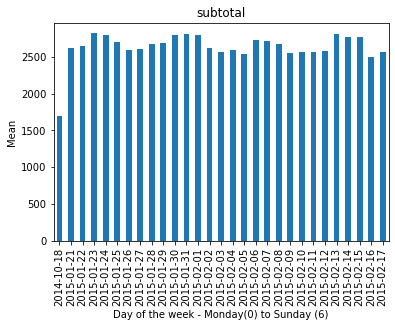

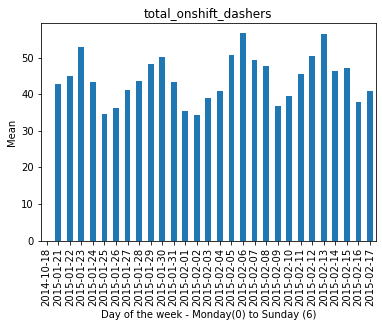

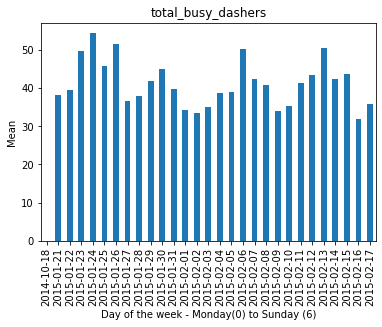

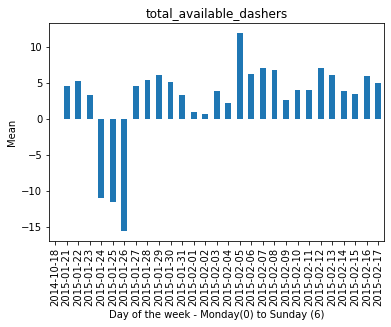

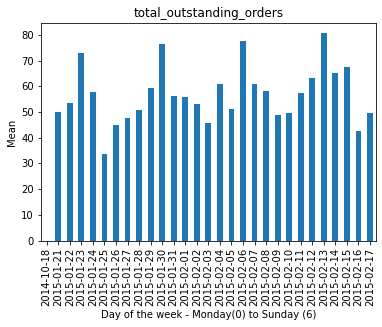

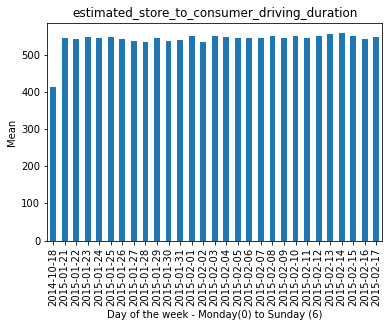

In [15]:
df1_group_by_date.count()[target_variable].plot.bar(title = 'Sample size')
plt.show()

for var in [target_variable] + continuous_varlist:
    df1_group_by_date.mean()[var].plot.bar(title = var)
    plt.xlabel("Day of the week - Monday(0) to Sunday (6)")
    plt.ylabel("Mean")
    plt.show()

### Found one outlier in 2014 - remove and check stability again

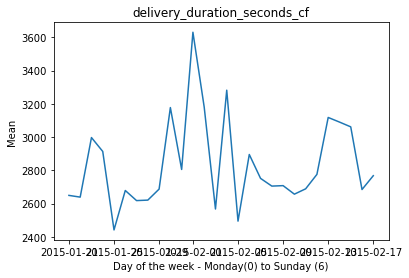

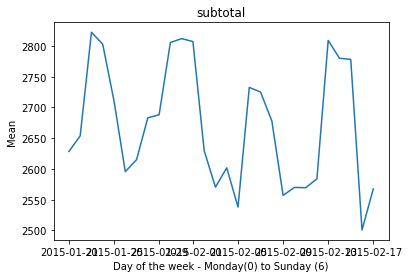

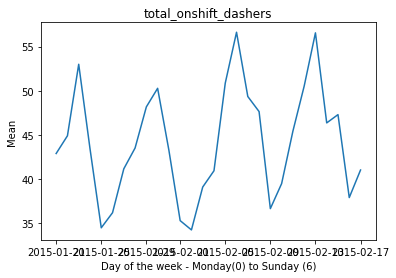

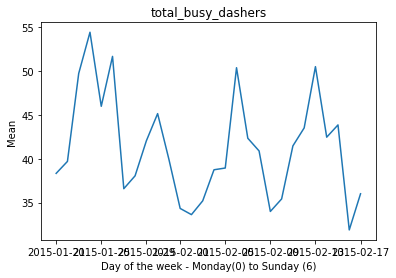

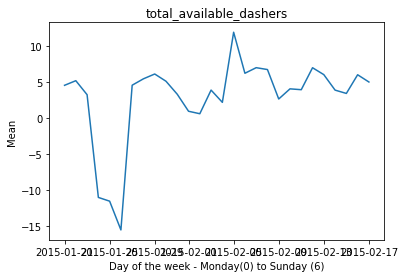

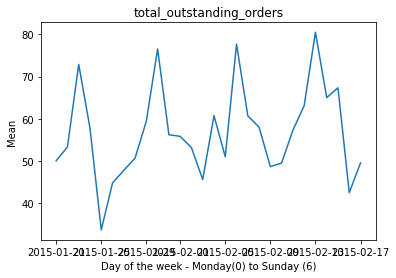

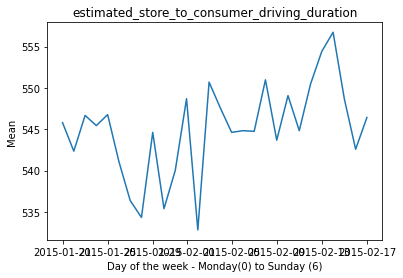

In [16]:
# number of samples in 2014
df2 = df1[df1['created_at'].dt.year == 2015]
df2_group_by_date = df2.groupby('created_date')

for var in [target_variable] + continuous_varlist:
    df2_group_by_date.mean()[var].plot.line(title = var)
    plt.xlabel("Day of the week - Monday(0) to Sunday (6)")
    plt.ylabel("Mean")
    plt.show()


### Day of week effect

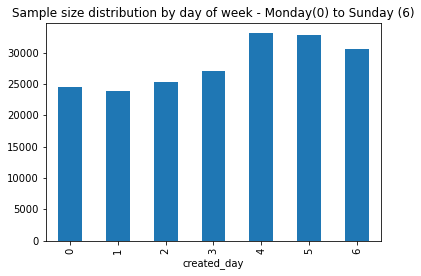

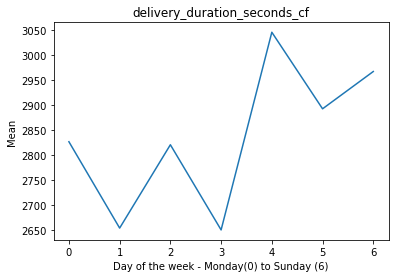

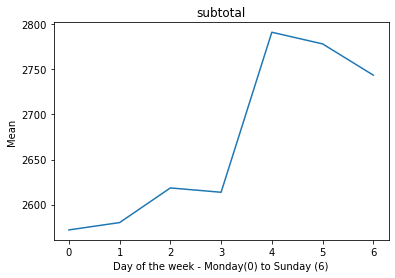

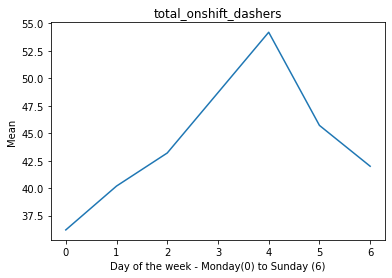

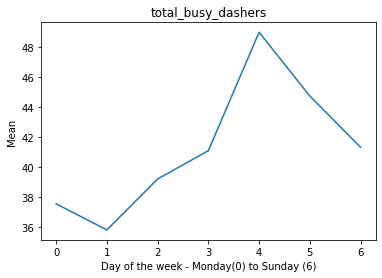

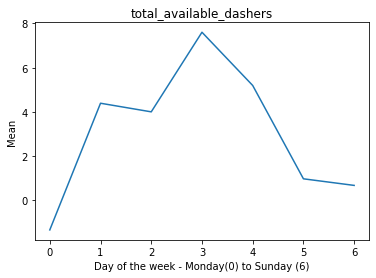

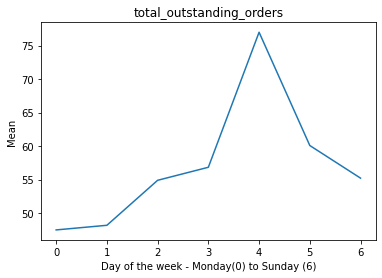

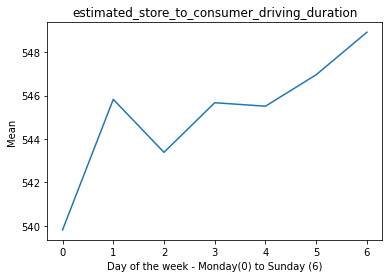

In [17]:
# sample size distribution
df1_group_by_day.count()[target_variable].plot.bar(title = 'Sample size distribution by day of week - Monday(0) to Sunday (6)')
plt.show()

# mean of target and continuous variable by day of week

for var in [target_variable] + continuous_varlist:
    df1_group_by_day.mean()[var].plot.line(title = var)
    plt.xlabel("Day of the week - Monday(0) to Sunday (6)")
    plt.ylabel("Mean")
    plt.show()

### Hour of day effect

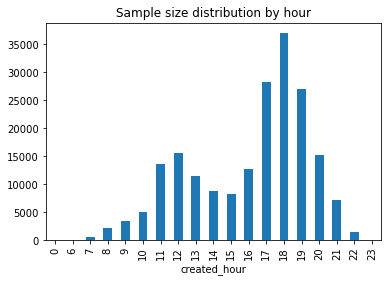

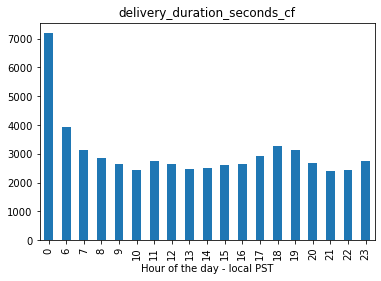

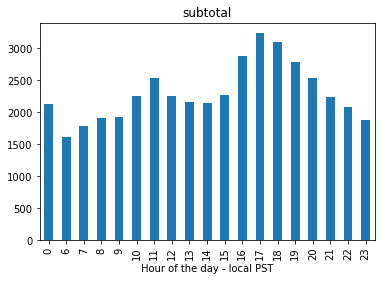

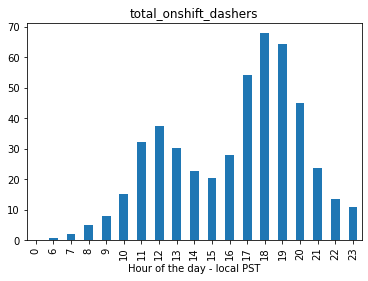

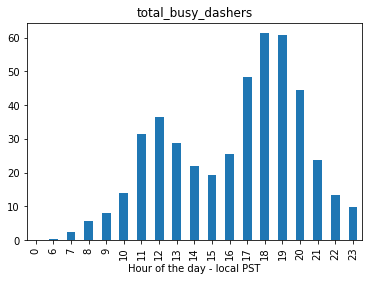

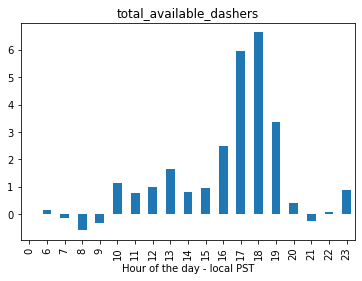

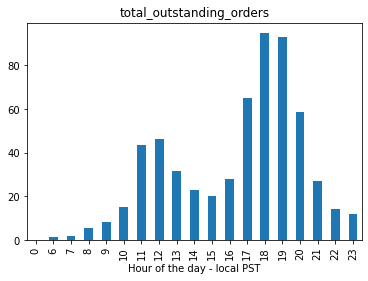

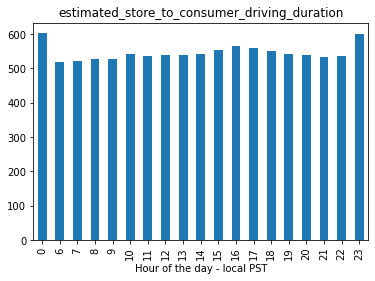

In [18]:
# sample size distribution
df1_group_by_hour.count()[target_variable].plot.bar(title = 'Sample size distribution by hour')
plt.show()

# mean of target and continuous variable by hour of day

for var in [target_variable] + continuous_varlist:
    df1_group_by_hour.mean()[var].plot.bar(title = var)
    plt.xlabel("Hour of the day - local PST")
    plt.show()

## Step 4: Univariate relationship between target and continuous variables

<Figure size 432x288 with 0 Axes>

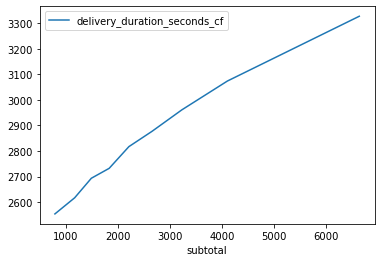

<Figure size 432x288 with 0 Axes>

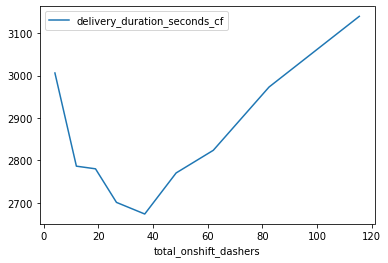

<Figure size 432x288 with 0 Axes>

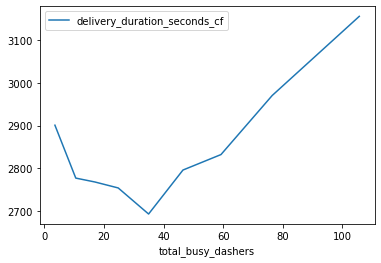

<Figure size 432x288 with 0 Axes>

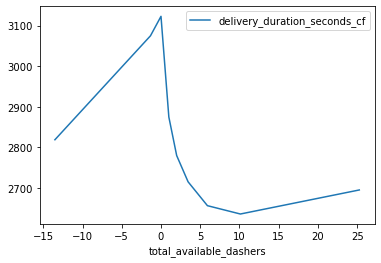

<Figure size 432x288 with 0 Axes>

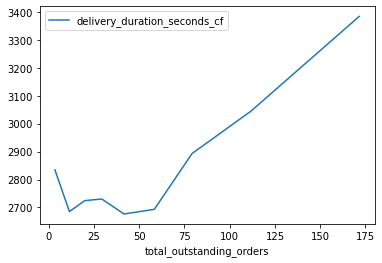

<Figure size 432x288 with 0 Axes>

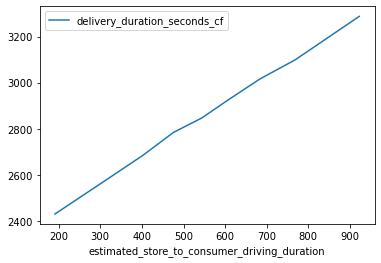

In [20]:
# separate into 20 equal bins

for xvar in continuous_varlist:
    df1[xvar+'_bin'] = pd.qcut(df1[xvar], 9, labels = False)
    grouped_mean = df1[[target_variable, xvar, xvar+'_bin']].groupby(xvar+'_bin').mean()
    plt.figure()
    grouped_mean.plot.line(xvar, target_variable)
    plt.show()
    

## Step 5: Missing patterns

In [21]:
df1[continuous_varlist].isna().sum()

subtotal                                            0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_available_dashers                         16262
total_outstanding_orders                        16262
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [22]:
for xvar in continuous_varlist:
    print (xvar, df1[df1[xvar].isna()][target_variable].mean())

subtotal nan
total_onshift_dashers 2840.907760423072
total_busy_dashers 2840.907760423072
total_available_dashers 2840.907760423072
total_outstanding_orders 2840.907760423072
estimated_store_to_consumer_driving_duration 2665.9505703422055


## Observation - negative available dashers
### Caused by some machanism or data issues?

In [108]:
## By definition, total available dashers is supposed to be positive. Why get negatives?
## create a flag to study the potential data issues

df2['neg_available_dashers'] = np.where(df2['total_notbusy_dashers'] < 0, 1, 0)
df2['neg_available_dashers'].value_counts(normalize = True)

KeyError: 'total_notbusy_dashers'

created_date
2015-01-24    0.687699
2015-01-25    0.650265
2015-01-26    0.660762
Name: neg_available_dashers, dtype: float64

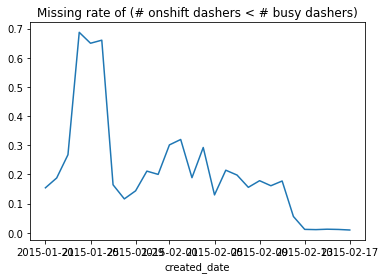

In [28]:
test = df2.groupby(['created_date'])['neg_available_dashers'].mean()
test.sort_index().plot.line(title = 'Missing rate of (# onshift dashers < # busy dashers)')
test[test> 0.5]